# 汇率预测
杨宇昊 3160105521 金融1601

## 预测原则
汇率的预测是有多个方面多个因子来影响的。但是这次小Project中，想测试单纯使用数学上的时间序列模型来进行预测。也即，只使用时间和历史汇率进行预测。显然这样的方法不够完善，但是也足够探讨目前最前沿的时间序列模型对于现实的拟合程度，并为大Project中的完整预测进行相应的铺垫。

## 数据来源
数据来自于Csmar国泰安的数据库，下载为`.txt`的格式，这次筛选了从2014-11-30到2018-11-30的完整数据。（所以也是最后一天才交的原因）将编码改为`UTF-8`以便使用`Pandas`导入。

## 模型依据
本次汇率预测采用的是业界最为先进和智能的来自`Facebook`的`Prophet`框架。它是一个时间序列的分析框架。时间序列预测对大部分公司而言都存在必要的需求，比如电商预测GMV，外卖O2O预测成交量波动以便于运力分配，酒店预测间夜量来调整定价与销售，等等。但通常而言，时间序列预测对不少公司来说是一个难题。主要原因除了时间序列预测本身就是玄学之外，还要求分析师同时具备深厚的专业领域知识（domain knowledge）和时间序列建模的统计学知识。此外，时间序列模型的调参也是一个比较复杂而繁琐的工作。
### 模型结构
Prophet的本质是一个加法模型，基本形式如下：
$$
y(t)=g(t)+s(t)+h(t)+\epsilon_t
$$
其中$g(t)$是趋势项，$s(t)$是周期项，$h(t)$是节假日项，$\epsilon_t$是误差项并且服从正态分布。
### 趋势模型
Prophet里使用了两种趋势模型：饱和增长模型（saturating growth model）和分段线性模型（piecewise linear model）。两种模型都包含了不同程度的假设和一些调节光滑度的参数，并通过选择变化点（changepoints）来预测趋势变化。最终形式：
#### 饱和增长模型
$$g(t)=\frac{C(t)}{1+exp(-(k+a(t)^T)\delta)(t-(m+a(t)^T\gamma)))}$$
#### 分段线性模型
$$g(t)=(k+a(t)^T\delta)t+(m+a(t)^T\gamma)$$
### 周期模型
prophet用傅里叶级数（Fourier series）来建立周期模型：
$$
s(t)=\sum_{n=1}^N(a_ncos(\frac{2\pi nt}{P})+b_nsin(\frac{2\pi nt}{P}))
$$
对N的调节起到了低通滤波（low-pass filter）的作用。作者说对于年周期与星期周期，N分别选取为10和3的效果比较好。

### 节假日与突发事件模型
节假日需要用户事先指定，每一个节假日都包含其前后的若干天。模型形式如下（就是一个虚拟变量）：
$$
Z(t)=[1(t\in D_1),\cdots,1(t\in D_L)]
$$
$$
h(t)=Z(t)\kappa
$$
$$
\kappa \sim Normarl(0,v^2)
$$

## 模型实战
### 平台搭建
操作系统为`Arch Linux x64`（Windows下`Prophet`无法正常工作）。
环境为`Anaconda`。语言使用`Python 3`。
通过添加`code-forge`的清华源并使用`conda install fbprophet`来安装`Prophet`框架。利用到了`numpy`和`pandas`来处理数据和矩阵。

### 导入框架

导入`Prophet`框架和`Pandas`框架。`add_changepoints_to_plot`是为了调整变点先验尺度（Changepoint Prior Scale）

In [1]:
import pandas as pd
import numpy as np
import math
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

### 导入数据
使用`Pandas`读取汇率历史文件，保存到`df`对象当中（表示`dataframe`的意思）将变量名调整为`ds`和`y`(时间变量和预测变量)，以便建模。将数据取对数处理，以使得预测尽可能贴近现实中的变动规律。最后一行展示导入的数据的前几行，检验是否导入成功。

In [2]:
df = pd.read_table('TRD_Exchange.txt')
df.columns=['ds','y'] 
df['y']=np.log(df['y'])
df.head()

,ds,y
0,2018-11-30,1.937576
1,2018-11-29,1.936624
2,2018-11-28,1.938742
3,2018-11-27,1.938209
4,2018-11-26,1.938065


### 建模调参
接下来开始建模以及调参。`m`是一个`Prophet`类型，来拟合刚刚的数据`df`。经过大量测试，发现变点先验尺度为0.5最为合适。同时，设定天和星期的周期变化为True。 变点先验尺度默认是0.05。变点先验尺度的直观含义是，对于每个拐点给予的权重。（可以通过二阶导判断拐点）。变点先验尺度过低会造成欠拟合的现象，过高会造成过拟合的现象。因为过低会不把拐点当拐点，会使得序列过于平稳，而过高则会把普通点当做拐点，序列波动非常剧烈。对于汇率，股票这样本身就变动剧烈的时间序列数据而言，倾向于增大变点先验尺度。至于为什么是0.5而不是0.1,0.8,0.6，这通常是一个工程问题而不是经济问题或者力量问题，因为这就是通过大量的尝试来判断拟合的是否合适。设定天和星期的周期变化为True也是如此来判断的。

In [4]:
m = Prophet(changepoint_prior_scale=0.8,weekly_seasonality=True,daily_seasonality=True)
m.fit(df)

### 预测准备
`future`是一个从`m`衍生的`Prophet`类型，设定`m`之后的32天的数据（也就是到1月1日）。
`cap`是一个设定的心理预期。因为在中美汇率当中，`7`是一个很明显的心理上限。值得注意的是，并不是设定了`7.0`的心理上限，数据就一定不会突破`7.0`。只是在接近`7.0`的时候，更倾向于下跌而不是上升。事实上，当我换一个时间区间或者或一个变点先验尺度，即便开启了`7.0`的上限，也是会轻松突破它的。

In [5]:
future = m.make_future_dataframe(periods=32)
future['cap'] = math.log(7.0)

### 开始预测
开始激动人心的预测！设定`future`变量为对`m`的预测，参数为之前的`future`.
我们只需要时间，预测值和置信空间，所以第二行这样设置。`ds`是时间，`yhat`是预测值，`yhat_lower`是置信区间下限，`yhat_upper`是置信区间上限。可以看到图形的预测结果如下。黑色是现实对应中的实际点，蓝线是拟合波动线，浅蓝空间是置信区间。变点先验尺度可以通过此图说明，当变点先验尺度越大，蓝线就会越倾向于模拟每一个点的波动而不是总体趋势，变点先验尺度越小，蓝线就倾向于模拟大的趋势而更容易忽略拐点。我们通过图表来查看预测结果。虽然是取过对数的，但是增长趋势是相同的。

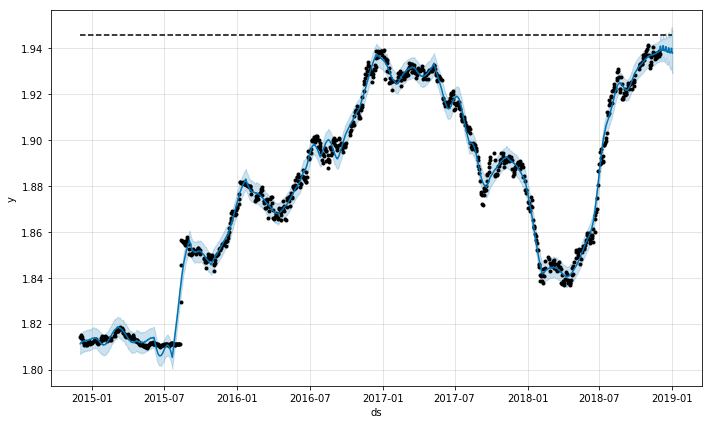

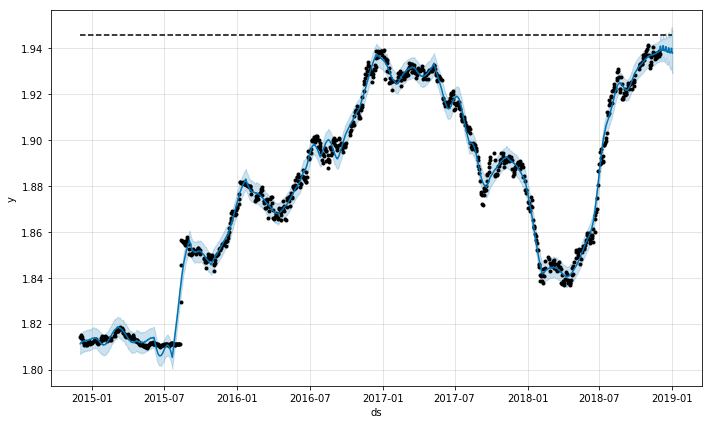

In [6]:
forecast = m.predict(future)
m.plot(forecast)

### 完整预测数据
接下来我们讲数据完整地打印出来，这时候将取过对数的转回来。我们只需要时间，预测值和置信空间。`ds`是时间，`yhat`是预测值，`yhat_lower`是置信区间下限，`yhat_upper`是置信区间上限。

In [7]:
forecast['yhat']=np.exp(forecast['yhat'])
forecast['yhat_lower']=np.exp(forecast['yhat_lower'])
forecast['yhat_upper']=np.exp(forecast['yhat_upper'])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(n=32)

,ds,yhat,yhat_lower,yhat_upper
978,2018-12-01,6.964242,6.933280,6.993948
979,2018-12-02,6.964794,6.936528,6.997172
980,2018-12-03,6.951700,6.918268,6.983508
981,2018-12-04,6.951802,6.919906,6.981625
982,2018-12-05,6.953643,6.920515,6.983620
983,2018-12-06,6.952458,6.919807,6.987371
984,2018-12-07,6.952993,6.918117,6.985471
985,2018-12-08,6.965982,6.932134,6.998609
986,2018-12-09,6.965814,6.933919,6.998736
987,2018-12-10,6.951999,6.919117,6.985858


## 总结
这次汇率预测的结果预测在2019-01-01的汇率为6.94，置信区间为6.88-7.01.显然，这个预测的置信区间还是过于大的。但是模型带给我们的自信是，**汇率将在十二月初短暂上升并很快走入缓慢下降的阶段**，对于这点，我对自己的模型还是充分信任的。事实上，通过调整参数和调整时间区间，对于2019-01-01的汇率预测值波动也是非常剧烈的，而一个最为稳妥的参数并不是那么轻易得到的。同时还有大量的因素尚未考虑（也许会出现在小组大论文当中）。总的来说，还是期待一个月后的开奖环节。